# Lesson 5: Human in the Loop

Note: This notebook is running in a later version of langgraph that it was filmed with. The later version has a couple of key additions:
- Additional state information is stored to memory and displayed when using `get_state()` or `get_state_history()`.
- State is additionally stored every state transition while previously it was stored at an interrupt or at the end.
These change the command output slightly, but are a useful addtion to the information available.

In [8]:
from dotenv import load_dotenv

_ = load_dotenv()

In [9]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.checkpoint.sqlite import SqliteSaver

memory_cm = SqliteSaver.from_conn_string(":memory:")
memory = memory_cm.__enter__()


In [10]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                print(f'inside reduce_messages: replace existing message with the same message id: {existing.id}')
                merged[i] = message
                break
        else:
            # append any new messages to the end
            print(f'inside reduce_messages: append new message with message id: {message.id} to list of messages')
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [11]:
tool = TavilySearch(max_results=2)

## Manual human approval

In [14]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )

        # Tool name normalization:
        # Different LangChain/LangGraph tool wrappers may emit slightly different tool-call names
        # (e.g. "tavily_search" vs "tavily_search_results_json"). We register common aliases.
        self.tools = {}
        for t in tools:
            primary = t.name
            self.tools[primary] = t
            if primary.endswith("_results_json"):
                self.tools.setdefault(primary.replace("_results_json", ""), t)
            else:
                self.tools.setdefault(primary + "_results_json", t)

        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        tool_calls = getattr(result, 'tool_calls', None) or []
        return len(tool_calls) > 0

    def _resolve_tool(self, name: str):
        tool = self.tools.get(name)
        if tool is not None:
            return tool

        # Try common Tavily / JSON-suffix variants
        if name.endswith("_results_json"):
            tool = self.tools.get(name.replace("_results_json", ""))
            if tool is not None:
                return tool
        else:
            tool = self.tools.get(name + "_results_json")
            if tool is not None:
                return tool

        return None

    def take_action(self, state: AgentState):
        last = state['messages'][-1]
        tool_calls = getattr(last, 'tool_calls', None) or []
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            tool = self._resolve_tool(t.get('name'))
            if tool is None:
                raise KeyError(f"Tool not found: {t.get('name')}. Available tools: {sorted(self.tools.keys())}")

            args = t.get('args') or {}
            result = tool.invoke(args)
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}


In [15]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-5-mini")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [16]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

inside reduce_messages: append new message with message id: b962c25e-27d6-4d6f-9886-77ca59b09d93 to list of messages
inside reduce_messages: append new message with message id: lc_run--019ba3f0-f8c5-7521-a1f3-edb690279608-0 to list of messages
{'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='b962c25e-27d6-4d6f-9886-77ca59b09d93'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 1342, 'total_tokens': 1443, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBBFrn6DQchNZojOnr8WqfiQaquy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--0

In [17]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='b962c25e-27d6-4d6f-9886-77ca59b09d93'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 1342, 'total_tokens': 1443, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBBFrn6DQchNZojOnr8WqfiQaquy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f0-f8c5-7521-a1f3-edb690279608-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'San Francisco current weather', 'search_depth': 'fast', 'topic': 'general'}, 'id': 'call_AkVzP6OwaeSdcuvbjpGfPpXF', 'type': 't

In [18]:
abot.graph.get_state(thread).next

('action',)

### continue after interrupt

In [19]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search', 'args': {'query': 'San Francisco current weather', 'search_depth': 'fast', 'topic': 'general'}, 'id': 'call_AkVzP6OwaeSdcuvbjpGfPpXF', 'type': 'tool_call'}
Back to the model!
inside reduce_messages: append new message with message id: fd66aeb8-c52b-4911-8a1f-2033e4066718 to list of messages
{'messages': [ToolMessage(content='{\'query\': \'San Francisco current weather\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'url\': \'https://www.localconditions.com/us/san-francisco/california/weather\', \'title\': \'San Francisco, CA Current Weather Today and Forecast with Radar | LocalConditions.com\', \'content\': "Home / Local Weather & Traffic / California / San Francisco / Current Weather. # San Francisco, CA Weather. ## Today\'s Weather in San Francisco,CA. The current weather in San Francisco CA as of 7:15 PM PST on Tue Jan 6th 2026, has a sky condition of Partly Cloudy with the visibility of 9 mile(s). The humidity i

In [20]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='b962c25e-27d6-4d6f-9886-77ca59b09d93'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 1342, 'total_tokens': 1443, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBBFrn6DQchNZojOnr8WqfiQaquy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f0-f8c5-7521-a1f3-edb690279608-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'San Francisco current weather', 'search_depth': 'fast', 'topic': 'general'}, 'id': 'call_AkVzP6OwaeSdcuvbjpGfPpXF', 'type': 't

In [21]:
abot.graph.get_state(thread).next

()

In [22]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

inside reduce_messages: append new message with message id: 846f4e18-3c3a-43a0-9ab8-2c7769a62b80 to list of messages
inside reduce_messages: append new message with message id: lc_run--019ba3f1-8af7-7dd1-9c52-58f8e9e153ae-0 to list of messages
{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='846f4e18-3c3a-43a0-9ab8-2c7769a62b80'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBBrN9oWjUUhhMhIYZLwgSxCL2LS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--0

proceed? y


Calling: {'name': 'tavily_search', 'args': {'query': 'Los Angeles weather now current temperature Los Angeles CA', 'search_depth': 'fast'}, 'id': 'call_vL0dvXLJ5SqtJW73xcvfAFs7', 'type': 'tool_call'}
Back to the model!
inside reduce_messages: append new message with message id: 682fd4d7-39ea-42a4-8539-2f5a80a63b93 to list of messages
{'messages': [ToolMessage(content='{\'query\': \'Los Angeles weather now current temperature Los Angeles CA\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'url\': \'https://www.usharbors.com/harbor/california/los-angeles-ca/weather/\', \'title\': \'Los Angeles, CA - Local Weather Today, 10-Day Forecasts | US Harbors\', \'content\': \'In Los Angeles, CA. The weather right now in Los Angeles, CA is Cloudy. The wind is currently blowing at 3 miles per hour, and coming from the South. The wind is gusting to 3 mph. With the wind and the atmosphere the temperature feels like 63° Fahrenheit.\', \'score\': 0.9092728, \'raw_cont

## Modify State
Run until the interrupt and then modify the state.

In [23]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

inside reduce_messages: append new message with message id: 332d8f01-4c8d-48e2-87d2-002025be455f to list of messages
inside reduce_messages: append new message with message id: lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0 to list of messages
{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--0

In [24]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Los Angeles weather now current temperature Los Angeles CA', 'search_depth': 'fast'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', '

In [25]:
current_values = abot.graph.get_state(thread)

In [26]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Los Angeles weather now current temperature Los Angeles CA', 'search_depth': 'fast'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1342, 'output_tokens': 102, 'total_tokens': 1444, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_

In [27]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'Los Angeles weather now current temperature Los Angeles CA',
   'search_depth': 'fast'},
  'id': 'call_BZDW9081KjotrFaIb8ngC4ib',
  'type': 'tool_call'}]

In [28]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
# IMPORTANT: tool_calls entries must include type="tool_call" in this pinned stack
current_values.values['messages'][-1].tool_calls = [
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'current weather in Louisiana'},
        'id': _id,
        'type': 'tool_call',
    }
]


In [29]:
abot.graph.update_state(thread, current_values.values)

inside reduce_messages: replace existing message with the same message id: 332d8f01-4c8d-48e2-87d2-002025be455f
inside reduce_messages: replace existing message with the same message id: lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0
{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d2

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ed863-8ec5-6916-8002-d57d6f8644b0'}}

In [30]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', 'type': 'tool_call'}], usage_metadata={'in

In [31]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', 'type': 'tool_call'}
Back to the model!
inside reduce_messages: append new message with message id: df8a65be-1c7f-4e07-a222-7b3fc5d8b811 to list of messages
{'messages': [ToolMessage(content='{\'query\': \'current weather in Louisiana\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': \'Weather in Louisiana\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.4411, \'lon\': -91.0551, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1767982128, \'localtime\': \'2026-01-09 12:08\'}, \'current\': {\'last_updated_epoch\': 1767981600, \'last_updated\': \'2026-01-09 12:00\', \'temp_c\': 6.1, \'temp_f\': 43.0, \'is_day\': 1, \'condition\': {\'text\': \'Overcast\', \'icon\': \'//cdn

## Time Travel

In [32]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', 'type': 'tool_call'}], usage_metadata={'in

To fetch the same state as was filmed, the offset below is changed to `-3` from `-1`. This accounts for the initial state `__start__` and the first state that are now stored to state memory with the latest version of software.

In [33]:
to_replay = states[-3]

In [34]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Los Angeles weather now current temperature Los Angeles CA', 'search_depth': 'fast'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', '

In [35]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search', 'args': {'query': 'Los Angeles weather now current temperature Los Angeles CA', 'search_depth': 'fast'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', 'type': 'tool_call'}
Back to the model!
inside reduce_messages: append new message with message id: cea07816-bbb1-40aa-a089-a9a365c624fa to list of messages
{'messages': [ToolMessage(content='{\'query\': \'Los Angeles weather now current temperature Los Angeles CA\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'url\': \'https://www.usharbors.com/harbor/california/los-angeles-ca/weather/\', \'title\': \'Los Angeles, CA - Local Weather Today, 10-Day Forecasts | US Harbors\', \'content\': \'In Los Angeles, CA. The weather right now in Los Angeles, CA is Cloudy. The wind is currently blowing at 3 miles per hour, and coming from the South. The wind is gusting to 3 mph. With the wind and the atmosphere the temperature feels like 63° Fahrenheit.\', \'score\': 0.9092728, \'raw_cont

## Go back in time and edit

In [36]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Los Angeles weather now current temperature Los Angeles CA', 'search_depth': 'fast'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', '

In [37]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
# IMPORTANT: tool_calls entries must include type="tool_call" in this pinned stack
to_replay.values['messages'][-1].tool_calls = [
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'current weather in LA, accuweather'},
        'id': _id,
        'type': 'tool_call',
    }
]


In [38]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

inside reduce_messages: replace existing message with the same message id: 332d8f01-4c8d-48e2-87d2-002025be455f
inside reduce_messages: replace existing message with the same message id: lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0
{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d2

In [39]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', 'type': 'tool_call'}
Back to the model!
inside reduce_messages: append new message with message id: cc7b021f-d344-482e-bf01-1c8da3bfad90 to list of messages
{'messages': [ToolMessage(content='{\'query\': \'current weather in LA, accuweather\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': \'Weather in Los Angeles, CA\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1767982180, \'localtime\': \'2026-01-09 10:09\'}, \'current\': {\'last_updated_epoch\': 1767981600, \'last_updated\': \'2026-01-09 10:00\', \'temp_c\': 10.6, \'temp_f\': 51.1, \'is_day\': 1, \'condition\': {\'text\': \'Sunny

## Add message to a state at a given time

In [40]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_BZDW9081KjotrFaIb8ngC4ib', 'type': 'tool_call'}], usage_metadat

In [41]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [42]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [43]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

inside reduce_messages: append new message with message id: 950371ce-29c4-4050-ad9a-ee999249ae22 to list of messages


In [44]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

inside reduce_messages: append new message with message id: lc_run--019ba3f3-8a7d-7a11-b77e-ae978db63a6b-0 to list of messages
{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='332d8f01-4c8d-48e2-87d2-002025be455f'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1342, 'total_tokens': 1444, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwBC91an2V6AID92tjaQ12ImKyLk3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba3f1-d284-77f2-a114-c62b74b66f84-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Los Angeles weather 

# Extra Practice

## Build a small graph
This is a small simple graph you can tinker with if you want more insight into controlling state memory.

In [45]:
from dotenv import load_dotenv

_ = load_dotenv()

In [46]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver

Define a simple 2 node graph with the following state:
-`lnode`: last node
-`scratch`: a scratchpad location
-`count` : a counter that is incremented each step

In [47]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [48]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

The graph goes N1->N2->N1... but breaks after count reaches 3.

In [49]:
def should_continue(state):
    return state["count"] < 3

In [50]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", 
                              should_continue, 
                              {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [51]:
memory2_cm = SqliteSaver.from_conn_string(":memory:")
memory2 = memory2_cm.__enter__()
graph = builder.compile(checkpointer=memory2)

### Run it!
Now, set the thread and run!

In [52]:
thread = {"configurable": {"thread_id": str(17)}}
graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

### Look at current state

Get the current state. Note the `values` which are the AgentState. Note the `config` and the `thread_ts`. You will be using those to refer to snapshots below.

In [53]:
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a58-6538-8004-57a54aaa5fb3'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-01-09T18:10:23.722210+00:00', parent_config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a54-630c-8003-46ce539f9aee'}}, tasks=(), interrupts=())

View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the *parent_config* is the *config* of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or *time travel* below.

### Look at state history

In [54]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a58-6538-8004-57a54aaa5fb3'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-01-09T18:10:23.722210+00:00', parent_config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a54-630c-8003-46ce539f9aee'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a54-630c-8003-46ce539f9aee'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-09T18:10:23.720516+00:00', parent_config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a51-6512-8002-7c8aae374f4e'}}, tasks=(PregelTask(id='0cfa610a-e604-731f-d0aa-9361eb974448', name='Node2', path=('__pregel_

Store just the `config` into an list. Note the sequence of counts on the right. `get_state_history` returns the most recent snapshots first.

In [55]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a58-6538-8004-57a54aaa5fb3'}} 4
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a54-630c-8003-46ce539f9aee'}} 3
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a51-6512-8002-7c8aae374f4e'}} 2
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a4d-6264-8001-49c9c760e0ff'}} 1
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a49-6ad8-8000-da6c6ec9794c'}} 0
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a48-603e-bfff-0165dbaca7c2'}} 0


Grab an early state.

In [56]:
states[-3]

{'configurable': {'thread_id': '17',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ed867-7a4d-6264-8001-49c9c760e0ff'}}

This is the state after Node1 completed for the first time. Note `next` is `Node2`and `count` is 1.

In [57]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a4d-6264-8001-49c9c760e0ff'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T18:10:23.717630+00:00', parent_config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a49-6ad8-8000-da6c6ec9794c'}}, tasks=(PregelTask(id='fcff44df-1ea0-53e6-37f6-0a3150420fee', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

### Go Back in Time
Use that state in `invoke` to go back in time. Notice it uses states[-3] as *current_state* and continues to node2,

In [58]:
graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

Notice the new states are now in state history. Notice the counts on the far right.

In [59]:
thread = {"configurable": {"thread_id": str(17)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aaf-689c-8004-72f71ce1fe43'}} 4
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aab-6c7e-8003-2a9483a21574'}} 3
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aa9-612c-8002-db6bbc25eb7a'}} 2
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a58-6538-8004-57a54aaa5fb3'}} 4
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a54-630c-8003-46ce539f9aee'}} 3
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a51-6512-8002-7c8aae374f4e'}} 2
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a4d-6264-8001-49c9c760e0ff'}} 1
{'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7a49-6ad8-8000-da6c6ec9794c'}} 0
{'configurable': {'thread_id': '17', 'checkpoint_ns': ''

You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent *config* is not the previous entry in the stack, but is the entry from state[-3].

In [60]:
thread = {"configurable": {"thread_id": str(17)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aaf-689c-8004-72f71ce1fe43'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-01-09T18:10:23.757931+00:00', parent_config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aab-6c7e-8003-2a9483a21574'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aab-6c7e-8003-2a9483a21574'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-09T18:10:23.756393+00:00', parent_config={'configurable': {'thread_id': '17', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aa9-612c-8002-db6bbc25eb7a'}}, tasks=(PregelTask(id='26d9c188-a7b0-2c2f-d7f6-49063695b9e0', name='Node2', path=('__pregel_

### Modify State
Let's start by starting a fresh thread and running to clean out history.

In [61]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch":"hi"},thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

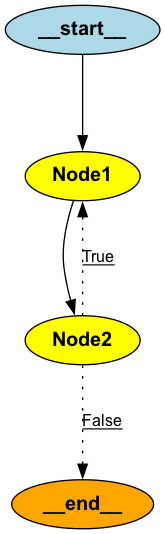

In [62]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [63]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])   

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7af3-6524-8004-3b6ccd942211'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aee-6196-8003-12d8990a5304'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7aea-671c-8002-89ee78c25445'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7ae5-692e-8001-69eec634a906'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7ae0-665e-8000-86025863e733'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7add-6fd0-bfff-84811cc10166'}} 0


Start by grabbing a state.

In [64]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7ae5-692e-8001-69eec634a906'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T18:10:23.780063+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7ae0-665e-8000-86025863e733'}}, tasks=(PregelTask(id='636a77a9-7dcf-37a5-eab8-071f51360d7f', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are *added* to the current value. Here, `-3` will be added to the current count value rather than replace it.

In [65]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7ae5-692e-8001-69eec634a906'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T18:10:23.780063+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7ae0-665e-8000-86025863e733'}}, tasks=(PregelTask(id='636a77a9-7dcf-37a5-eab8-071f51360d7f', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now update the state. This creates a new entry at the *top*, or *latest* entry in memory. This will become the current state.

In [66]:
graph.update_state(thread2,save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ed867-8bb0-6fc4-8005-2cb6b7a575d9'}}

Current state is at the top. You can match the `thread_ts`.
Notice the `parent_config`, `thread_ts` of the new node - it is the previous node.

In [67]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8bb0-6fc4-8005-2cb6b7a575d9'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2026-01-09T18:10:25.541102+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7af3-6524-8004-3b6ccd942211'}}, tasks=(PregelTask(id='8dbcdcbc-a586-5cb7-a87d-94069b352867', name='Node1', path=('__pregel_pull', 'Node1'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-7af3-6524-8004-3b6ccd942211'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-01-09T18:10:23.785695+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': 

### Try again with `as_node`
When writing using `update_state()`, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the `next()` value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges!  Let's try this out.

In [68]:
graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ed867-8bcc-6e9a-8006-284292debc72'}}

In [69]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8bcc-6e9a-8006-284292debc72'}}, metadata={'source': 'update', 'step': 6, 'parents': {}}, created_at='2026-01-09T18:10:25.552537+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8bb0-6fc4-8005-2cb6b7a575d9'}}, tasks=(PregelTask(id='fd49c984-20a9-6728-9ef4-44d054fcf2f9', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8bb0-6fc4-8005-2cb6b7a575d9'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2026-01-09T18:10:25.541102+00:00', parent_config={'configurable': {'thread_id': '2', 'ch

`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.

In [70]:
graph.invoke(None,thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

Print out the state history, notice the `scratch` value change on the latest entries.

In [71]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8c00-674a-800b-6d9e5f156c75'}}, metadata={'source': 'loop', 'step': 11, 'parents': {}}, created_at='2026-01-09T18:10:25.573652+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8bfa-6fd4-800a-7aabe0e55774'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8bfa-6fd4-800a-7aabe0e55774'}}, metadata={'source': 'loop', 'step': 10, 'parents': {}}, created_at='2026-01-09T18:10:25.571414+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed867-8bf7-6e4c-8009-b2b6a8e20767'}}, tasks=(PregelTask(id='f6d4f610-4986-7397-5d59-2c8ed1e115d9', name='Node2', path=('__pre

Continue to experiment!

In [72]:
# Cleanup: close checkpoint connections opened via __enter__ (recommended at end of notebook)
try:
    memory_cm.__exit__(None, None, None)
except NameError:
    pass

try:
    memory2_cm.__exit__(None, None, None)
except NameError:
    pass
